In [1]:
import os
import json
from tqdm import tqdm


import torch
import numpy as np

from transformers import AutoTokenizer

from utils.loader import lvlm_loader
from utils.utils import generate, return_attention, compute_tile_weights, return_weights, valuable_weights
from utils.metrics import compute_score

import matplotlib.pyplot as plt
from PIL import Image
from transformers import GenerationConfig
from transformers import StoppingCriteria, StoppingCriteriaList

class StopOnToken(StoppingCriteria):
    def __init__(self, stop_token_id):
        self.stop_token_id = stop_token_id

    def __call__(self, input_ids, scores, **kwargs):
        if input_ids[0][-1] == self.stop_token_id:
            return True
        return False

from glob import glob

from dataclasses import dataclass

/home/baekig/.conda/envs/vrag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
@dataclass
class Config():
    model_id = '' 
args=Config()
args.model_id = 'Qwen/Qwen2-VL-7B-Instruct'
args.bos_as_weight = False
args.norm = False
args.do_ablation = False
args.fine_grained = True
args.do_masking = False
args.do_ablation = False
ppp = ["img_dataset_an"]

def load_data(metadata, number, fg = False):
    path = 'img_dataset_an/'
    img_paths = sorted(glob(path + f'{number}/*'))
    evidence_page = int(list(metadata[number][f'{str(number)}']['bboxes_per_chunk'].keys())[0])
    bbox = list(metadata[number][f'{str(number)}']['bboxes_per_chunk'].values())[0]
    answer = metadata[number][f'{str(number)}']["answer"]
    try:
        question = metadata[number]["question"]
    except: question = ''
    return img_paths, evidence_page, bbox, answer, question

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model, processor = lvlm_loader(args.model_id, device = device, args = args)
model.eval()
tokenizer = AutoTokenizer.from_pretrained(args.model_id, trust_remote_code=True)

args.processor = processor

model.config.use_cache = False
model.gradient_checkpointing_disable

a


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 5/5 [00:28<00:00,  5.66s/it]


<bound method PreTrainedModel.gradient_checkpointing_disable of Qwen2VLForConditionalGeneration(
  (visual): Qwen2VisionTransformerPretrainedModel(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
    )
    (rotary_pos_emb): VisionRotaryEmbedding()
    (blocks): ModuleList(
      (0-31): 32 x Qwen2VLVisionBlock(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): VisionSdpaAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): VisionMlp(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): QuickGELUActivation()
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        )
      )
    )
    (merger): PatchMerger(
      (ln_q): LayerNo

In [5]:
if 'intern' in args.model_id.lower():
    n_heads = model.config.llm_config.num_attention_heads
    n_layer = model.config.llm_config.num_hidden_layers
    q_s, q_i, q_e = 92544, 92546, 92545
else:
    n_heads = model.config.num_attention_heads # 10
    n_layer = model.config.num_hidden_layers # 12
    q_s, q_i, q_e = 151652, 151655, 151653
import string
chars = list(string.digits + string.ascii_lowercase)

In [7]:
features, mean_features = {}, {}
for ch in chars:
    features[ch] = {}
    mean_features[ch] = {}
    for layer in range(n_layer):
        for head in range(n_heads):
            features[ch][f'l{layer}_h{head}'] = []
            mean_features[ch][f'l{layer}_h{head}'] = []
        
pp = "img_dataset_an"
_number = 0
if args.fine_grained: metadata_path = f"{pp}/bbox_fg.json"
else: metadata_path = f"{pp}/bbox.json"
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

In [8]:
error = []
for number in tqdm(range(len(metadata))):
    if metadata[number][f'{str(number)}']['bboxes_per_chunk'] == {}:
        continue
    if _number == 0:
        img_paths, evidence_page, bbox, answer, _ = load_data(metadata, number)
    else: img_paths, evidence_page, bbox, answer, question = load_data(metadata, number)
    label_img_path = img_paths[evidence_page]
    label_img=Image.open(label_img_path)
    label_array=np.array(label_img)
    args.label_array = label_array
    
    if args.fine_grained:
        input_content = [{"type": "image", "image": f'''{label_img_path}'''}]
        messages = [{"role": "user", "content": input_content}]
        weights_list, new_weight_list = [], []
        
        for box_len in range(len(bbox)):
            xmin, ymin, xmax, ymax = bbox[box_len]
            weights=return_weights(args, messages, xmin, ymin, xmax, ymax)
            weights_list.append(weights)
            new_weight = valuable_weights(weights)
            new_weight_list.append(new_weight)
                    
    else:
        xmin, ymin, xmax, ymax = bbox

        input_content = [{"type": "image", "image": f'''{label_img_path}'''}]
        messages = [{"role": "user", "content": input_content}]
        weights=return_weights(args, messages, xmin, ymin, xmax, ymax)
        new_weight = valuable_weights(weights)
        
    
    if 'qwen' in args.model_id.lower():
        input_content = [{"type": "image", "image": f'''{path}'''} for path in img_paths]
        
        if _number == 0:
            input_content.append({"type": "text", "text": '''What is the pass key?'''})
        else:
            input_content.append({"type": "text", "text": f'''{question}'''})
            
        outputs, generated_ids_trimmed, output_text, with_sp_output_text, inputs = generate(args, model, tokenizer, processor, input_content=input_content)
        start_ids = torch.nonzero(inputs.input_ids.squeeze().to('cpu') == q_s).squeeze() +1
        end_ids = torch.nonzero(inputs.input_ids.squeeze().to('cpu') == q_e).squeeze() -1
        
    elif 'internvl' in args.model_id.lower():
        
        num_patches = len(img_paths)
        num_image_token = model.num_image_token
        IMG_START_TOKEN = "<img>"
        IMG_END_TOKEN   = "</img>"
        IMG_CONTEXT_TOKEN = "<IMG_CONTEXT>"

        image_tokens = IMG_START_TOKEN + (IMG_CONTEXT_TOKEN * (num_image_token * num_patches)) + IMG_END_TOKEN
        if _number == 0:
            user_question = "What is the passkey?"
        else: user_question = f"{question}"
        
        prompt = f"{image_tokens}\n{user_question}" 
        model_inputs = tokenizer(prompt, return_tensors="pt")
        input_ids = model_inputs["input_ids"].to("cuda")
        attention_mask = model_inputs["attention_mask"].to("cuda")
        
        model.img_context_token_id = tokenizer.convert_tokens_to_ids(IMG_CONTEXT_TOKEN)   
        generation_config = GenerationConfig(
            max_new_tokens=32,
            do_sample=False,
        )
        from utils.utils import load_image
        pixel_values = torch.cat([load_image(path, max_num = 1).to(torch.float16).cuda() for path in img_paths], dim = 0)
        stop_token_id = 281 
        stopping_criteria = StoppingCriteriaList([StopOnToken(stop_token_id)])
        
        with torch.no_grad():
            outputs = model.generate(
                pixel_values=pixel_values,
                input_ids=input_ids,   
                attention_mask=attention_mask,  
                return_dict_in_generate=True,
                output_attentions=True,
                generation_config=generation_config,
                stopping_criteria=stopping_criteria
            )
        generated_ids_trimmed=[outputs.sequences.squeeze(dim = 0)]
        inputs = input_ids
            
        n_of_imgs= int(torch.sum(torch.where(input_ids == 92546, 1, 0)).item() / 256)
        start_num = torch.nonzero(input_ids.squeeze().to('cpu') == q_s).item() +1
        start_ids = start_num + 256 * torch.arange(0, n_of_imgs)
        

    attentions = outputs['attentions']
    
    pattern_list = tokenizer(str(answer))
    
    tmp, context_idx, ans_idx = [], [], []
   
    for n, tok in enumerate(generated_ids_trimmed[0].to('cpu').tolist()):
        if 'qwen' in args.model_id.lower():
            if tok in pattern_list.input_ids:
                ans_idx.append(inputs.input_ids.shape[1] + n)
                
        elif 'internvl' in args.model_id.lower():
            if tok in pattern_list.input_ids[1:]:
                ans_idx.append(inputs.shape[1] + n)
                
    for layer in range(n_layer):
        for head in range(n_heads):
            
            attn = return_attention(args.model_id, attentions, layer = layer, head_n = head, 
                                    norm = args.norm, bos_as_weight= args.bos_as_weight)
            if 'qwen' in args.model_id.lower():
                image_retrieval_score = compute_score(pattern_list.input_ids, outputs.sequences.squeeze().to('cpu').tolist())
            elif 'internvl' in args.model_id.lower():
                image_retrieval_score = compute_score(pattern_list.input_ids[1:], outputs.sequences.squeeze().to('cpu').tolist())
            
            if args.fine_grained:
                for box_len in range(len(bbox)):
                    pos_attn_position = set([weight + start_ids[evidence_page].item() for weight in list(new_weight_list[box_len].keys())])
                    
                    score = 0
                    try:
                        index = torch.argmax(attn[ans_idx[box_len],:-len(generated_ids_trimmed[0])]).item()            
                    except:
                        continue
                    if index in pos_attn_position:
                        features[answer][f"l{str(layer)}_h{str(head)}"].append(image_retrieval_score)
                        
                    else:
                        features[answer][f"l{str(layer)}_h{str(head)}"].append(0)
                    
                        
            else:
                pos_attn_position = set([weight + start_ids[evidence_page].item() for weight in list(new_weight.keys())])
                score = 0
                for ans in ans_idx:
                    index = torch.argmax(attn[ans,:-len(generated_ids_trimmed[0])]).item()            
                    
                    if index in pos_attn_position:
                        features[answer][f"l{str(layer)}_h{str(head)}"].append(image_retrieval_score)
                    else:
                        features[answer][f"l{str(layer)}_h{str(head)}"].append(0)

  0%|          | 0/3600 [00:00<?, ?it/s]

Qwen2VLModel is using Qwen2VLSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
The attention layers in this model are transitioning from computing the RoPE embeddings internally through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed `position_embeddings` (Tuple of tensors, containing cos and sin). In v4.46 `position_ids` will be removed and `position_embeddings` will be mandatory.
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


In [9]:
import numpy as np


for ch, feats in features.items():
    for head_name, values in feats.items():

        if values:
            mean_features[ch][head_name] = np.mean(values)
        else:
            mean_features[ch][head_name] = float("-inf")  


for ch, means in mean_features.items():
    
    sorted_heads = sorted(
        means.items(),
        key=lambda item: item[1],
        reverse=True
    )
    top5 = sorted_heads[:5]
    
    print(f"Character '{ch}' top-5 heads:")
    for head_name, mean_val in top5:
        print(f"  {head_name}: {mean_val:.4f}")
    print()

Character '0' top-5 heads:
  l21_h25: 0.6812
  l17_h24: 0.6667
  l19_h20: 0.6522
  l3_h8: 0.6377
  l3_h11: 0.6377

Character '1' top-5 heads:
  l19_h20: 0.8841
  l3_h8: 0.6667
  l17_h24: 0.6667
  l14_h8: 0.6522
  l2_h4: 0.6377

Character '2' top-5 heads:
  l8_h24: 0.7681
  l14_h8: 0.7681
  l14_h13: 0.7681
  l3_h8: 0.7246
  l19_h20: 0.7246

Character '3' top-5 heads:
  l19_h20: 0.8116
  l5_h19: 0.7971
  l17_h24: 0.7681
  l14_h13: 0.7536
  l3_h8: 0.7246

Character '4' top-5 heads:
  l17_h24: 0.7826
  l3_h8: 0.6667
  l3_h11: 0.6667
  l19_h20: 0.6667
  l2_h4: 0.6522

Character '5' top-5 heads:
  l19_h20: 0.7971
  l14_h8: 0.6667
  l17_h24: 0.6667
  l3_h8: 0.6377
  l3_h11: 0.6377

Character '6' top-5 heads:
  l3_h8: 0.7391
  l14_h8: 0.7391
  l19_h20: 0.7101
  l11_h0: 0.6522
  l14_h13: 0.6522

Character '7' top-5 heads:
  l3_h8: 0.8696
  l14_h8: 0.7681
  l19_h20: 0.7101
  l16_h9: 0.6522
  l3_h11: 0.6377

Character '8' top-5 heads:
  l14_h8: 0.7536
  l14_h13: 0.6957
  l3_h8: 0.6667
  l2_h4: 0.

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_char_heatmaps(mean_features, n_layers, n_heads, output_dir="char_heatmaps"):
    os.makedirs(output_dir, exist_ok=True)

    for ch, heads_dict in mean_features.items():
        mat = np.zeros((n_layers, n_heads))
        for layer in range(n_layers):
            for head in range(n_heads):
                key = f"l{layer}_h{head}"
                mat[layer, head] = heads_dict.get(key, 0.0)

        # 2) figure 생성
        plt.figure()
        plt.imshow(mat, aspect="auto") 
        plt.title(f"Heatmap for '{ch}'", pad=8)
        plt.xlabel("Head index")
        plt.ylabel("Layer index")
        plt.tight_layout()

In [11]:
def plot_top5_heads(mean_features, output_dir="plots_top5"):

    import os
    os.makedirs(output_dir, exist_ok=True) 

    for ch, heads_dict in mean_features.items():
        
        sorted_heads = sorted(heads_dict.items(), key=lambda x: x[1], reverse=True)[:5]
        labels, values = zip(*sorted_heads)

        plt.figure()
        plt.bar(labels, values)
        plt.title(f"'{ch}' top-5 heads", pad=8)
        plt.xlabel("Head")
        plt.ylabel("Mean value")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(f"{output_dir}/top5_{ch}.png", dpi=300)
        plt.close()

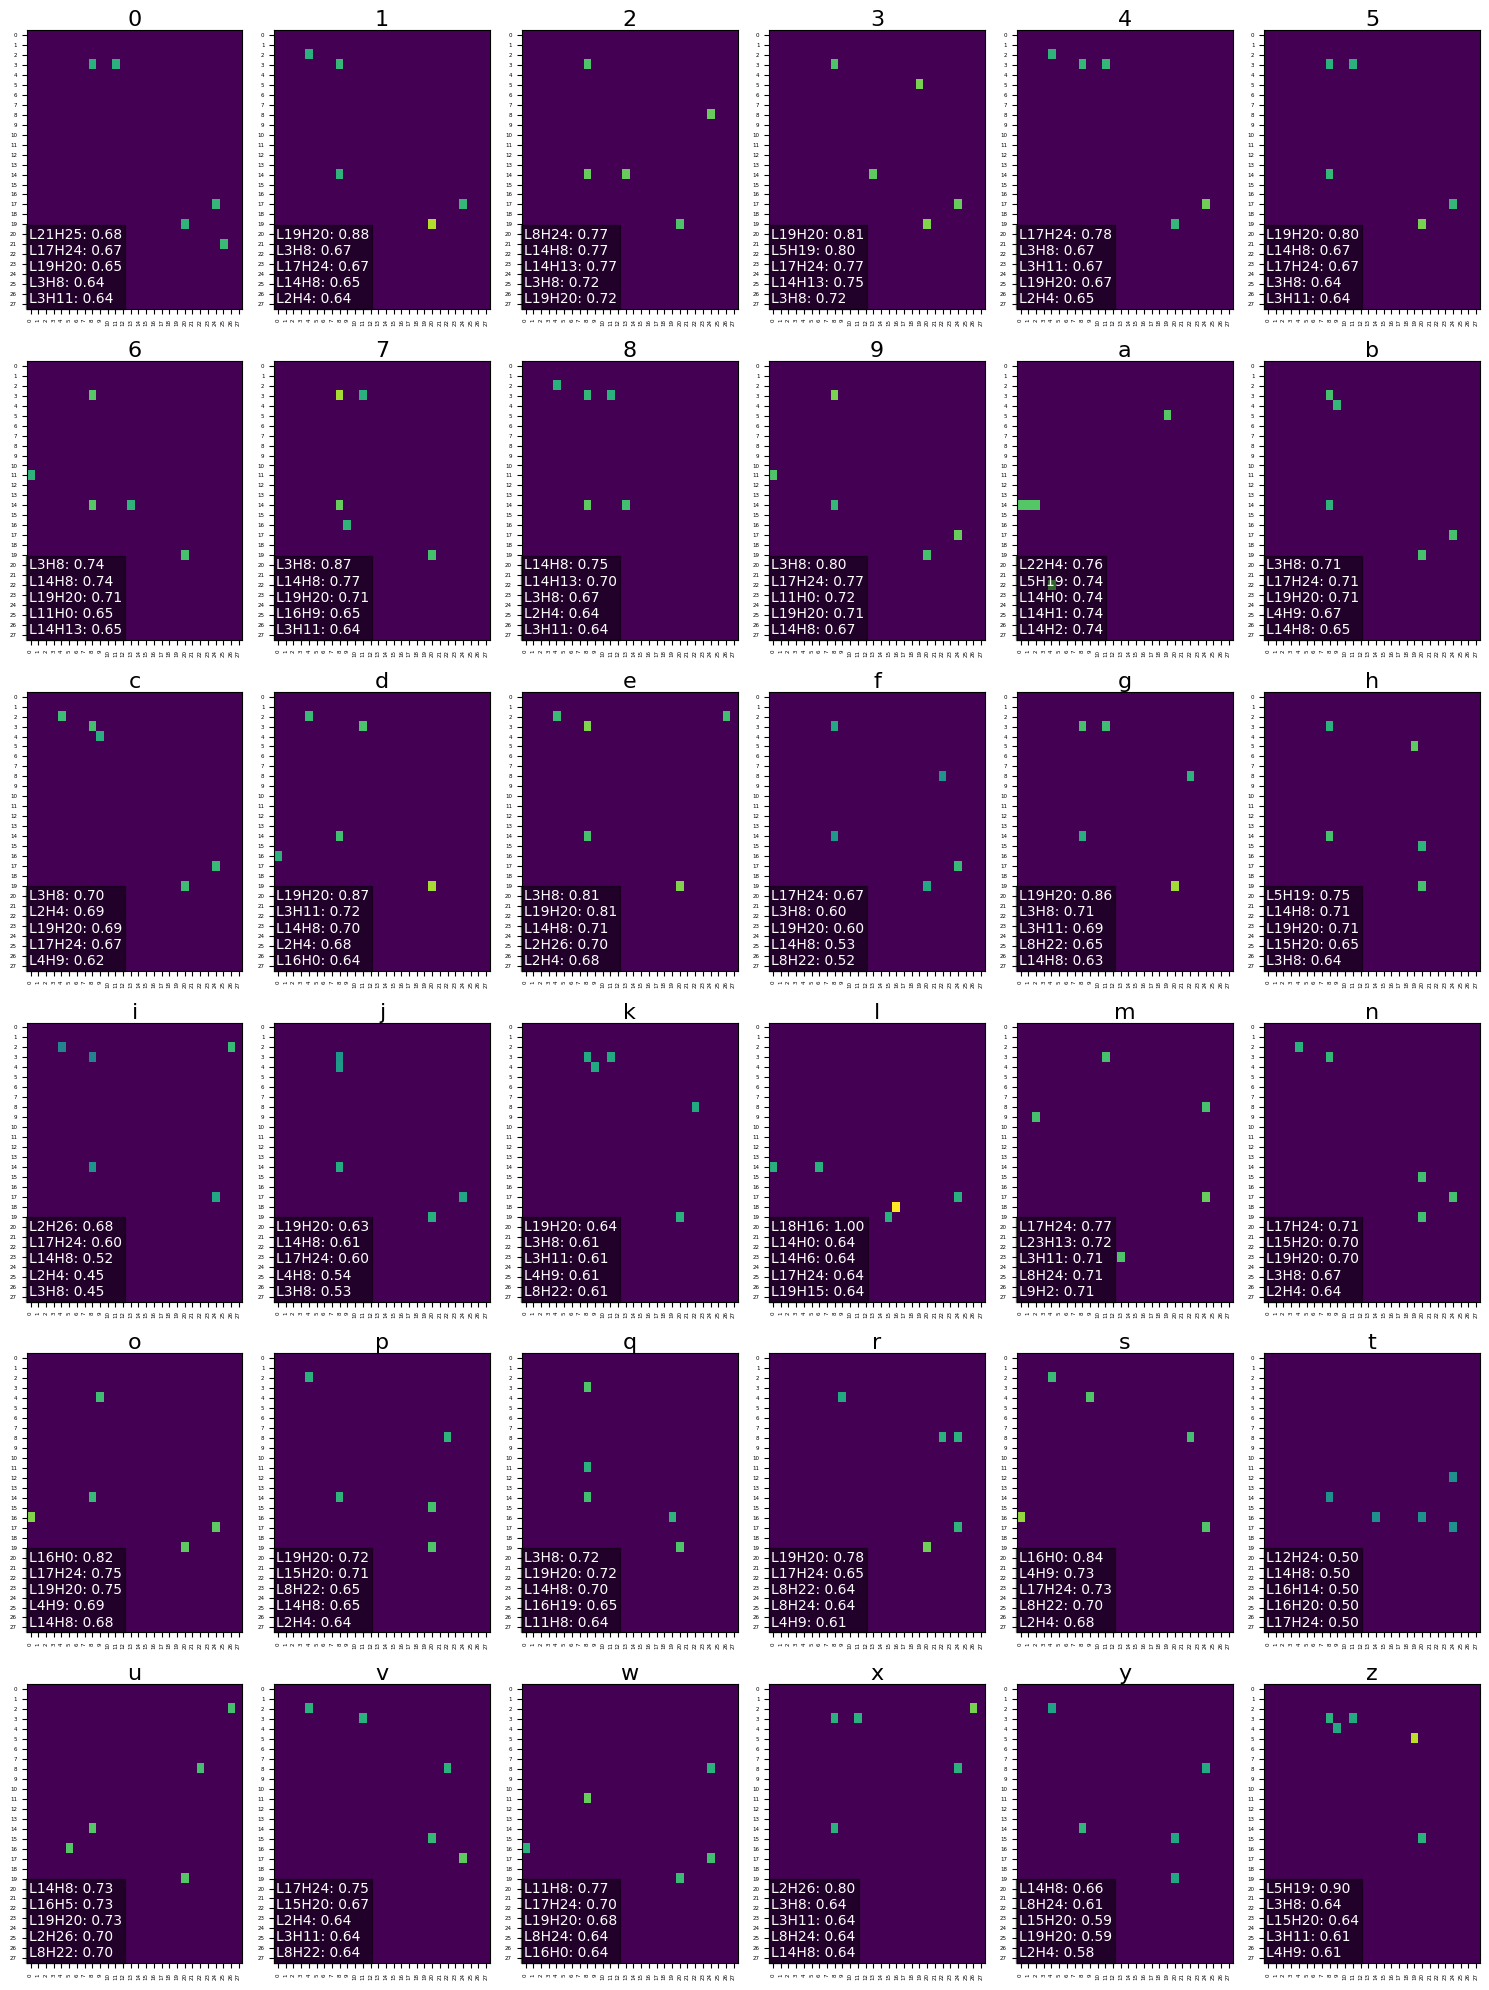

In [13]:
import math
import os, math
import numpy as np
import matplotlib.pyplot as plt


def plot_char_top5_heatmaps_grid(
    mean_features: dict,
    n_layers: int,
    n_heads: int,
    chars: list = None,
    cols: int = 6,
    figsize: tuple = (18, 18),
    cmap: str = "viridis",
    save_path: str = None
):
    if chars is None:
        chars = sorted(mean_features.keys())
    total = len(chars)
    rows = math.ceil(total / cols)

    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False)

    all_vals = [
        mean_features[ch].get(f"l{l}_h{h}", 0.0)
        for ch in chars
        for l in range(n_layers)
        for h in range(n_heads)
    ]
    vmin, vmax = min(all_vals), max(all_vals)

    for idx, ch in enumerate(chars):
        r, c = divmod(idx, cols)
        ax = axes[r][c]

        mat = np.array([
            [mean_features[ch].get(f"l{l}_h{h}", 0.0) for h in range(n_heads)]
            for l in range(n_layers)
        ])

        flat = mat.flatten()
        sorted_items = sorted(enumerate(flat), key=lambda x: x[1], reverse=True)
        top5 = sorted_items[:5]
        mask = np.zeros_like(mat, dtype=bool)
        for idx_flat, _ in top5:
            l = idx_flat // n_heads
            h = idx_flat % n_heads
            mask[l, h] = True
        vis_mat = np.where(mask, mat, 0)

        # 3) 히트맵
        im = ax.imshow(vis_mat, aspect="auto", vmin=vmin, vmax=vmax, cmap=cmap)

        ax.set_xticks(np.arange(n_heads))
        ax.set_xticklabels([f"{h}" for h in range(n_heads)],
                           fontsize=4, rotation=90)
        ax.set_yticks(np.arange(n_layers))
        ax.set_yticklabels([f"{l}" for l in range(n_layers)],
                           fontsize=4)

        ax.set_title(ch, pad=2, fontsize=16)
        
        lines = [f"L{idx_flat//n_heads}H{idx_flat%n_heads}: {val:.2f}"
                 for idx_flat, val in top5]
        annotation = "\n".join(lines)
        ax.text(
            0.01, 0.01, annotation,
            transform=ax.transAxes,
            va="bottom", ha="left",
            color="white", fontsize=10,
            bbox=dict(facecolor="black", alpha=0.5, pad=2)
        )

    for idx in range(total, rows * cols):
        r, c = divmod(idx, cols)
        axes[r][c].axis("off")


    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()
chars = list(string.digits + string.ascii_lowercase)
sample = next(iter(mean_features.values()))
layers = [int(k.split('_')[0][1:]) for k in sample.keys()]
heads  = [int(k.split('_')[1][1:]) for k in sample.keys()]
n_layers = max(layers) + 1
n_heads  = max(heads)  + 1

plot_char_top5_heatmaps_grid(
    mean_features=mean_features,
    n_layers=n_layers,
    n_heads=n_heads,
    chars=chars,
    cols=6,
    figsize=(15, 20),
    cmap="viridis",
    save_path="figure/top5_heatmap_grid.pdf" 
)